In [8]:
%pip install torch torchvision torchsummary
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import json
import os
from MiraBest_Goof import MiraBest

Note: you may need to restart the kernel to use updated packages.


In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

In [75]:
trainset = MiraBest(root='../batches', train=True, download=True, transform=transform)  
batch_size_train = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

Files already downloaded and verified


In [76]:
testset = MiraBest(root='../batches', train=False, download=True, transform=transform) 
batch_size_test = 2
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True, num_workers=2)

Files already downloaded and verified


In [200]:
test_len = 0
for i, data in enumerate(testloader, 0):
    x, y = data
    test_len += x.shape[0]
train_len = 0
for i, data in enumerate(trainloader, 0):
    x, y = data
    train_len += x.shape[0]
print(test_len)
print(train_len)


77
693


In [201]:
dataset_sizes = {"train": train_len, "test": test_len}

In [373]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        # self.fc1 = nn.Linear(16 * 73 * 73, 120) 
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(3*36*36, 2) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 3*36*36)
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [374]:
net = Net()
summary(net,(1,150,150))
loss = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 148, 148]              30
            Conv2d-2            [-1, 3, 72, 72]              84
            Linear-3                    [-1, 2]           7,778
Total params: 7,892
Trainable params: 7,892
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.62
Params size (MB): 0.03
Estimated Total Size (MB): 0.74
----------------------------------------------------------------


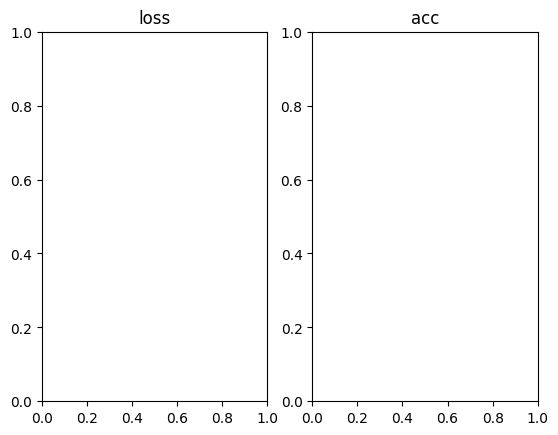

In [375]:
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="acc")

y_loss = {}
y_loss["train"] = []
y_loss["test"] = []
y_acc = {}
y_acc["train"] = []
y_acc["test"] = []
#https://sybernix.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388

def draw_curve():
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['test'], 'ro-', label='test')
    ax1.plot(x_epoch, y_acc['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_acc['test'], 'ro-', label='test')
    file_name = "train_" + str(len(x_epoch)) + ".jpg"
    fig.savefig(os.path.join('../lossGraphs', file_name))

In [376]:
for epoch in range(10):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch+1, 10))
    for phase in ["train", "test"]:     
        running_loss = 0.0
        running_corrects = 0.0 
        if(phase == "train"):
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                images, labels = data
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        else:
            net.train(False)
            for i, data in enumerate(testloader, 0):
                images, labels = data
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{}: Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        y_loss[phase].append(epoch_loss)
        y_acc[phase].append(epoch_acc)
        if(phase == "test"):
            x_epoch.append(epoch)
            draw_curve()
        

----------
Epoch 1/10
train: Loss: 0.7263 Acc: 0.5368
test: Loss: 0.6903 Acc: 0.5584
----------
Epoch 2/10
train: Loss: 0.6907 Acc: 0.5584
test: Loss: 0.6798 Acc: 0.5584
----------
Epoch 3/10
train: Loss: 0.6778 Acc: 0.5945
test: Loss: 0.6577 Acc: 0.5584
----------
Epoch 4/10
train: Loss: 0.6554 Acc: 0.6277
test: Loss: 0.6194 Acc: 0.7273
----------
Epoch 5/10
train: Loss: 0.6230 Acc: 0.6638
test: Loss: 0.6027 Acc: 0.7273
----------
Epoch 6/10
train: Loss: 0.5941 Acc: 0.6825
test: Loss: 0.5869 Acc: 0.6494
----------
Epoch 7/10
train: Loss: 0.5743 Acc: 0.6970
test: Loss: 0.5803 Acc: 0.6623
----------
Epoch 8/10
train: Loss: 0.5580 Acc: 0.6984
test: Loss: 0.5765 Acc: 0.7143
----------
Epoch 9/10
train: Loss: 0.5458 Acc: 0.7229
test: Loss: 0.5834 Acc: 0.7013
----------
Epoch 10/10
train: Loss: 0.5330 Acc: 0.7374
test: Loss: 0.5825 Acc: 0.7013
